# Import modules

In [1]:

import torch
import torch.optim as optim
from tensordict import TensorDict
import matplotlib.pyplot as plt
from models.autoencoder import KoopmanAutoencoder
from models.utils import load_checkpoint, load_config, get_dataset_class_and_kwargs, load_datasets
from models.dataloader import create_dataloaders
from models.metrics import Metric
from models.cnn import TransformerConfig
from matplotlib import gridspec
import seaborn as sns

cmap = sns.color_palette("icefire", as_cmap=True)

# Configuration


In [2]:
CONFIG_PATH = "/home/rg625/mnt/ocean_forecasting/koopman_autoencoder/configs/model/128_inc.yaml"  # Update this path
CKPT_PATH = '/home/rg625/mnt/ocean_forecasting/koopman_autoencoder/model_outputs/128_inc_kl_1.0/20250606_100205/best_model.pth'  # Set to specific checkpoint if needed, otherwise loads best/final

ROLL_OUT_STEPS = 70  # Number of future time steps to predict
VISUALIZE = True     # Toggle to show visualizations
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
config = load_config(CONFIG_PATH)
config['training']['use_checkpoint'] = False  # Don't checkpoint during testing

dataset_class, dataset_kwargs = get_dataset_class_and_kwargs(config)
train_dataset, val_dataset, test_dataset = load_datasets(config, dataset_class, dataset_kwargs)
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    config=config
)

self.means.items(): dict_items([('p', tensor(0.0004)), ('v_x', tensor(0.4416)), ('v_y', tensor(-2.7021e-05)), ('obstacle_mask', tensor(0.9634))])
self.stds.items(): dict_items([('p', tensor(0.0045)), ('v_x', tensor(0.2195)), ('v_y', tensor(0.1707)), ('obstacle_mask', tensor(0.1878))])
self.means.items(): dict_items([('p', tensor(0.0005)), ('v_x', tensor(0.4374)), ('v_y', tensor(-0.0002)), ('obstacle_mask', tensor(0.9634))])
self.stds.items(): dict_items([('p', tensor(0.0045)), ('v_x', tensor(0.2234)), ('v_y', tensor(0.1543)), ('obstacle_mask', tensor(0.1878))])
self.means.items(): dict_items([('p', tensor(0.0003)), ('v_x', tensor(0.4423)), ('v_y', tensor(0.0001)), ('obstacle_mask', tensor(0.9634))])
self.stds.items(): dict_items([('p', tensor(0.0045)), ('v_x', tensor(0.2188)), ('v_y', tensor(0.1724)), ('obstacle_mask', tensor(0.1878))])


#  Load Model 


In [4]:
model = KoopmanAutoencoder(
    input_frames=config["data"]["input_sequence_length"],
    input_channels=config["model"]["input_channels"],
    height=config["model"]["height"],
    width=config["model"]["width"],
    latent_dim=config["model"]["latent_dim"],
    hidden_dims=config["model"]["hidden_dims"],
    use_checkpoint=config["training"]["use_checkpoint"],
    transformer_config=TransformerConfig(**config["model"]["transformer"]),
    predict_re=config["model"]["predict_re"],
    **config["model"]["conv_kwargs"],
).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=config["lr_scheduler"]["lr"])

if CKPT_PATH is not None:
    print(f"Loading from checkpoint: {CKPT_PATH}")
    model, _, _, _ = load_checkpoint(CKPT_PATH, model=model, optimizer=optimizer)

model.eval()

Loading from checkpoint: /home/rg625/mnt/ocean_forecasting/koopman_autoencoder/model_outputs/128_inc_kl_1.0/20250606_100205/best_model.pth
Resuming training from epoch 182.


KoopmanAutoencoder(
  (history_encoder): HistoryEncoder(
    (linear): Linear(in_features=8192, out_features=1024, bias=True)
    (layers): Sequential(
      (0): ConvBlock(
        (stack): ModuleList(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          (3): ReLU()
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ConvBlock(
        (stack): ModuleList(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          (1): ReLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          (3): ReLU()
        )
      )
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): ConvBlock(
        (s

#  Run Rollout


In [5]:
def run_long_rollout(model, input_seq, rollout_steps):
    input_seq = input_seq.unsqueeze(0).to(DEVICE)  # [1, T, C, H, W]

    with torch.no_grad():
        out = model(input_seq, seq_length=rollout_steps)

    return out  # [T+rollout_steps, C, H, W]

#  Visualize


In [6]:
input_seq, ground_truth = test_dataset.__getitem__((0, ROLL_OUT_STEPS))  # [T, C, H, W]

total_predicted_seq = run_long_rollout(model, input_seq, ROLL_OUT_STEPS)
predicted_seq = total_predicted_seq.x_preds.cpu()
print(total_predicted_seq)

KoopmanOutput(x_recon=TensorDict(
    fields={
        p: Tensor(shape=torch.Size([1, 64, 128]), device=cuda:0, dtype=torch.float32, is_shared=True),
        v_x: Tensor(shape=torch.Size([1, 64, 128]), device=cuda:0, dtype=torch.float32, is_shared=True),
        v_y: Tensor(shape=torch.Size([1, 64, 128]), device=cuda:0, dtype=torch.float32, is_shared=True)},
    batch_size=torch.Size([1]),
    device=None,
    is_shared=False), x_preds=TensorDict(
    fields={
        p: Tensor(shape=torch.Size([1, 70, 64, 128]), device=cuda:0, dtype=torch.float32, is_shared=True),
        v_x: Tensor(shape=torch.Size([1, 70, 64, 128]), device=cuda:0, dtype=torch.float32, is_shared=True),
        v_y: Tensor(shape=torch.Size([1, 70, 64, 128]), device=cuda:0, dtype=torch.float32, is_shared=True)},
    batch_size=torch.Size([1]),
    device=None,
    is_shared=False), z_preds=tensor([[[-2.5370e-01,  5.3995e-01, -3.4629e-01,  ...,  6.7154e-01,
          -2.1140e+00,  3.7064e-02],
         [-3.6679e-01,  3

#  Plot Results 


In [7]:
def compute_vorticity(vx, vy):
    vxDx, vxDy = torch.gradient(vx, dim=(1, 2))  # vx: [T, H, W]
    vyDx, vyDy = torch.gradient(vy, dim=(1, 2))
    return vyDx - vxDy  # [T, H, W]

def plot_rollout(gt_dict, pred_dict, variable_name, frame_stride=5):
    """
    Plots the rollout comparison between ground truth and predicted sequence for a given variable.

    Args:
        gt_dict (TensorDict): TensorDict of ground truth tensors [T, H, W] per variable.
        pred_dict (TensorDict): TensorDict of predicted tensors [T, H, W] per variable.
        variable_name (str): The key for the variable to visualize.
        frame_stride (int): Step between frames to plot.
    """
    # Remove batch dimension if present
    if gt_dict.batch_dims == 1 and gt_dict.batch_size[0] == 1:
        gt_dict = gt_dict.squeeze(0)
    if pred_dict.batch_dims == 1 and pred_dict.batch_size[0] == 1:
        pred_dict = pred_dict.squeeze(0)

    gt = gt_dict[variable_name]  # shape: [T, H, W]
    pred = pred_dict[variable_name]  # shape: [T, H, W]

    print(f"Max {variable_name} (GT): {gt.max()}")
    print(f"Max {variable_name} (Pred): {pred.max()}" )

    num_frames = min(gt.shape[0], pred.shape[0])
    indices = list(range(0, num_frames, frame_stride))
    num_plots = min(len(indices), 15)

    fig = plt.figure(figsize=(1.8 * num_plots, 6))
    spec = gridspec.GridSpec(2, num_plots + 1, width_ratios=[1] * num_plots + [0.05])

    for i, idx in enumerate(indices[:num_plots]):
        # Ground truth
        ax_gt = fig.add_subplot(spec[0, i])
        ax_gt.imshow(gt[idx].cpu(), cmap=cmap)
        ax_gt.set_title(f"t={idx}")
        ax_gt.axis('off')

        # Prediction
        ax_pred = fig.add_subplot(spec[1, i])
        im_pred = ax_pred.imshow(pred[idx].cpu(), cmap=cmap)
        ax_pred.axis('off')

    # Add shared colorbar
    cbar_ax = fig.add_subplot(spec[:, -1])
    fig.colorbar(im_pred, cax=cbar_ax)

    fig.suptitle(f"Koopman AE Rollout for Variable: {variable_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.4, 0.98, 0.95])
    plt.show()

TensorDict(
    fields={
        Re: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        p: Tensor(shape=torch.Size([70, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        seq_length: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
        v_x: Tensor(shape=torch.Size([70, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_y: Tensor(shape=torch.Size([70, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)
TensorDict(
    fields={
        p: Tensor(shape=torch.Size([70, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_x: Tensor(shape=torch.Size([70, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_y: Tensor(shape=torch.Size([70, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)


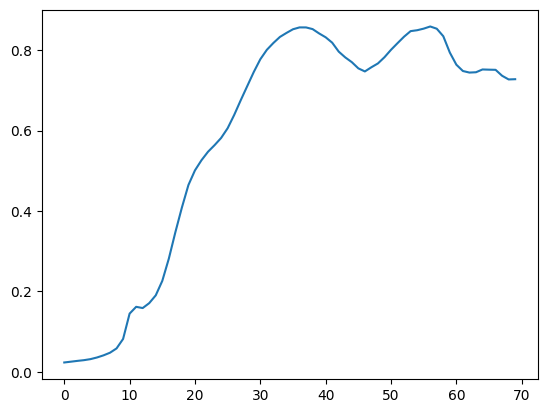

In [8]:
metric = Metric(
    mode=config["metric"]["type"],
    variable_mode=config["metric"]["variable_mode"]
)
target_denorm = test_loader.denormalize(ground_truth)
preds_denorm = test_loader.denormalize(predicted_seq.squeeze())

# Map both to [0, 1] using dataset min/max
target_unit = test_loader.to_unit_range(target_denorm)
preds_unit = test_loader.to_unit_range(preds_denorm)
print(target_unit)
print(preds_unit)
ipt = TensorDict(
    {
    "reference": target_unit,
    "other": preds_unit, 
    }
)
loss = metric(ipt)
print(f"\nLong Rollout {config['metric']['type']} Metric: {loss.mean().item():.4f}")
plt.plot(loss.squeeze().cpu().detach().numpy())
plt.show()

true Re: 500.0
true Re: tensor([552.3370, 525.8325, 492.0204, 457.0421, 426.1817, 403.0664, 388.8025,
        382.6710, 384.7654, 395.9246, 400.6502, 339.4598, 226.6039, 121.4719,
         52.0220,  11.0946,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000])


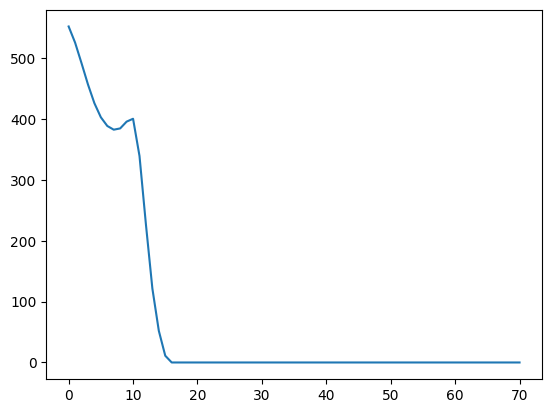

Max p (GT): 9.06871223449707
Max p (Pred): 14572.2109375


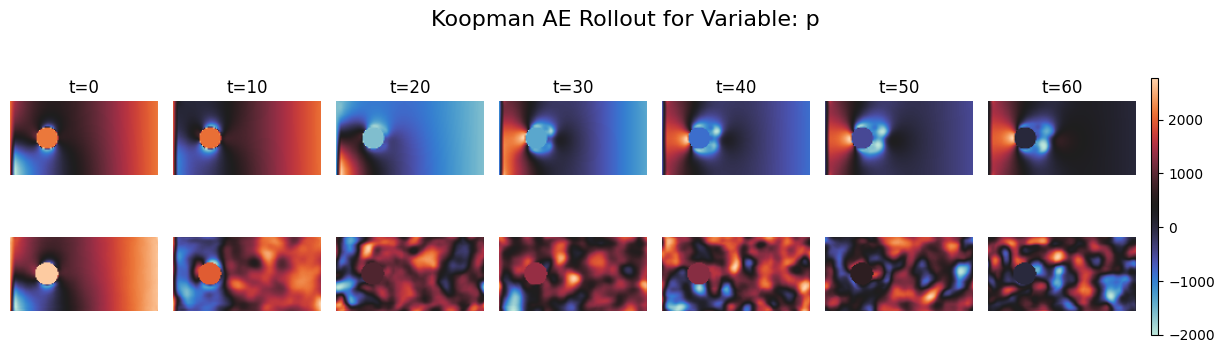

Max v_x (GT): 2.1027488708496094
Max v_x (Pred): 15537.142578125


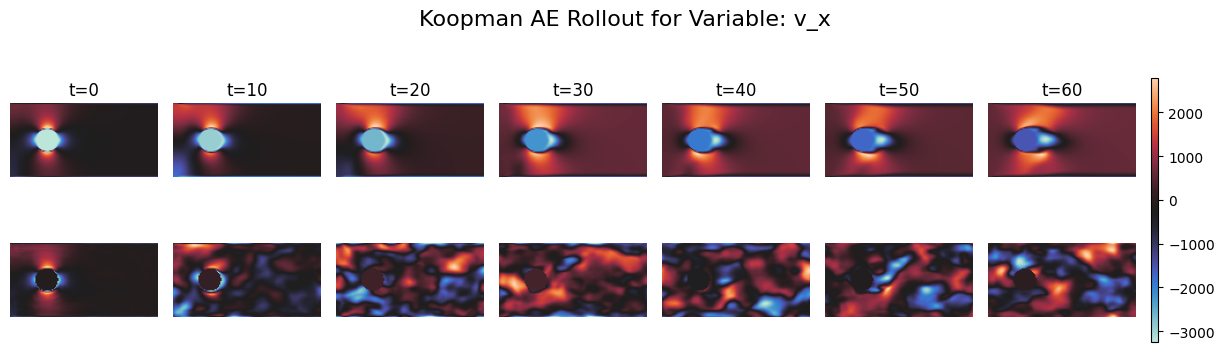

Max v_y (GT): 2.6453311443328857
Max v_y (Pred): 10260.3984375


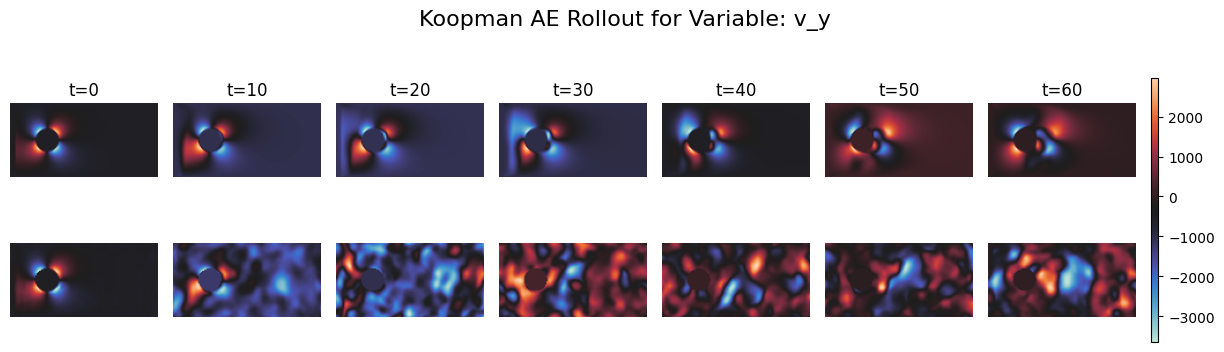

Max vort (GT): 2.239215850830078
Max vort (Pred): 5364.2060546875


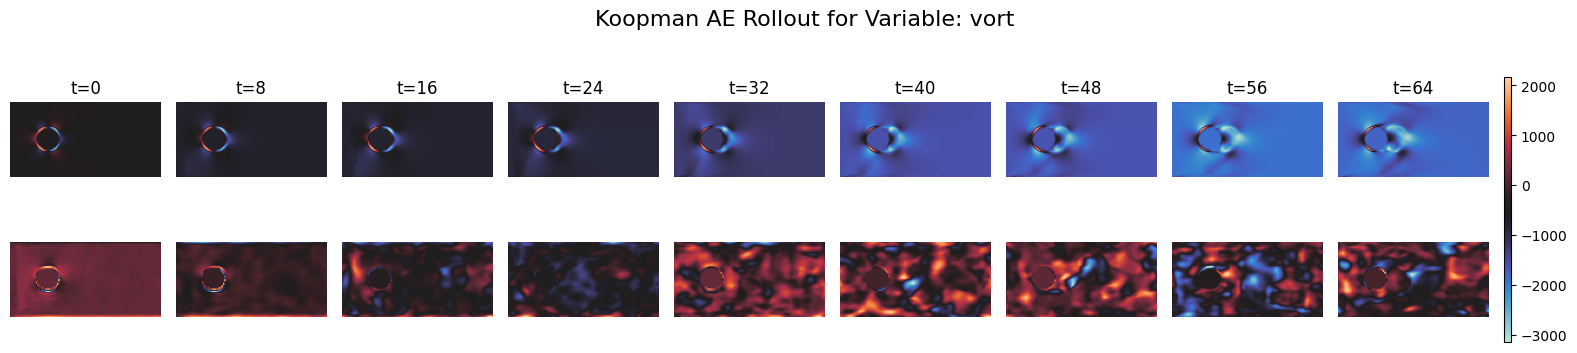

In [11]:
print(f'true Re: {ground_truth["Re"]}')
print(f'true Re: {total_predicted_seq.reynolds.squeeze().cpu()}')
plt.plot(total_predicted_seq.reynolds.squeeze().cpu())
plt.show()
plot_rollout(ground_truth.cpu(), predicted_seq.cpu(), variable_name="p", frame_stride=10)
plot_rollout(ground_truth.cpu(), predicted_seq.cpu(), variable_name="v_x", frame_stride=10)
plot_rollout(ground_truth.cpu(), predicted_seq.cpu(), variable_name="v_y", frame_stride=10)

# Compute vorticity from vx and vy
vort_gt = compute_vorticity(ground_truth["v_x"], ground_truth["v_y"])
vort_pred = compute_vorticity(predicted_seq["v_x"], predicted_seq["v_y"])

# Add derived vorticity to the TensorDicts
ground_truth["vort"] = vort_gt
predicted_seq["vort"] = vort_pred

# Plot vorticity
plot_rollout(ground_truth.cpu(), predicted_seq.cpu(), variable_name="vort", frame_stride=8)